In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt

C:\Users\Peter\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Здесь я попробую собрать последовательность действий, которую надо сделать, чтобы выделить плохих и хороших пользователей

# Выделение хороших и плохих покупателей

In [2]:
cust = pd.read_csv("hackathon/customers.csv")
ord_ = pd.read_csv("hackathon/orders.csv")

Проверяем наны

In [3]:
cust.isna().sum(), ord_.isna().sum()

(customer_id                 0
 customer_unique_id          0
 customer_zip_code_prefix    0
 customer_city               0
 customer_state              0
 dtype: int64,
 order_id                            0
 customer_id                         0
 order_status                        0
 order_purchase_timestamp            0
 order_approved_at                 160
 order_delivered_carrier_date     1783
 order_delivered_customer_date    2965
 order_estimated_delivery_date       0
 dtype: int64)

Пока уберём столбцы с нанами, чтобы не мозолили глаза и не вызывали ошибки

In [4]:
ord_ = ord_.drop(columns=["order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date"])

Объединяем по индексу покупателя(этот индекс нужен только для объединения датасетов), дальше нам нужен будет только customer_unique_id

In [5]:
cust_with_ord = cust.join(ord_.set_index("customer_id"), on="customer_id")

In [6]:
cust_with_ord

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-08-15 00:00:00
...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-25 00:00:00
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-20 00:00:00
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-05-02 00:00:00
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-12-05 00:00:00


Чтобы тоже не было проблем повыкидываем временно не нужные столбцы(нам нужны только "customer_unique_id", "order_id", "order_purchase_timestamp", "order_status")

In [7]:
cust_with_ord = cust_with_ord[["customer_unique_id", "order_id", "order_purchase_timestamp", "order_status"]]

In [8]:
cust_with_ord["order_status"].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Выделим заказы, которые не "canceled", не "unavailable", не "processing" и не "created"

In [9]:
cust_with_ord = cust_with_ord[(cust_with_ord["order_status"] != "canceled")*1.0 + 
                              (cust_with_ord["order_status"] != "unavailable")*1.0 + 
                              (cust_with_ord["order_status"] != "created")*1.0 + 
                              (cust_with_ord["order_status"] != "processing")*1.0 == 4]

Сгруппируем людей по их id и посмотрим на распределение количества заказов среди них

<Axes: xlabel='order_id', ylabel='Count'>

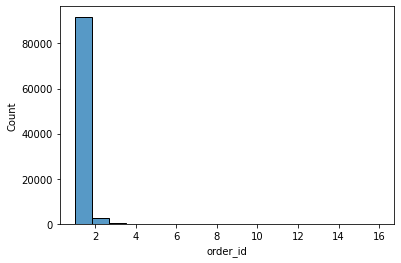

In [10]:
sns.histplot(cust_with_ord.groupby("customer_unique_id")["order_id"].count())

Выделим id пользователей, которые сделали больше одной покупки

In [11]:
good_boys = cust_with_ord.groupby("customer_unique_id").filter(lambda x: x["customer_unique_id"].count() > 1)["customer_unique_id"].unique()

In [12]:
good_boys.shape

(2876,)

In [13]:
good_boys.shape[0]/cust_with_ord["customer_unique_id"].unique().shape[0]

0.030369908869153844

Получаем наши 3% хороших пользователей

Вытащим просто часть датасета с заказами людей, сделавших больше 1 заказа

In [14]:
orders_good = cust_with_ord.groupby("customer_unique_id").filter(lambda x: x["customer_unique_id"].count() > 1)

<Axes: xlabel='count', ylabel='Count'>

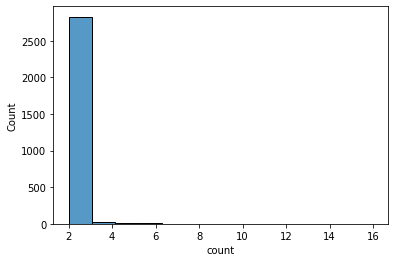

In [15]:
sns.histplot(orders_good["customer_unique_id"].value_counts())

Переведём строки во время

In [16]:
orders_good["order_purchase_timestamp"] = pd.to_datetime(orders_good["order_purchase_timestamp"])

Для подсчёта разниц во времени между первым и вторым заказом:

1) Группируем по id
2) выделяем timestapm
3) применяем функцию, где сортируем внутри группы и вычитаем из времени второй покупки время первой

In [17]:
time_diffs_12 = orders_good.groupby("customer_unique_id")["order_purchase_timestamp"].apply(lambda x: (np.sort(x)[1] - np.sort(x)[0]))

In [18]:
np.array(time_diffs_12).shape

(2876,)

Посмотрим на то, что плучилось

Text(0.5, 0, 'days')

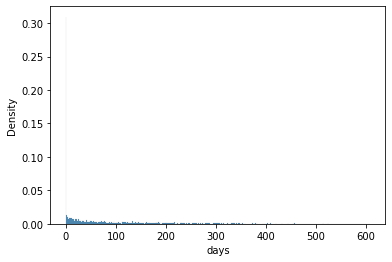

In [19]:
sns.histplot((np.array(time_diffs_12)/1e9/3600/24), stat="density")
plt.xlabel("days")
# plt.grid()

Видим выстрел в нуле, который надо обработать

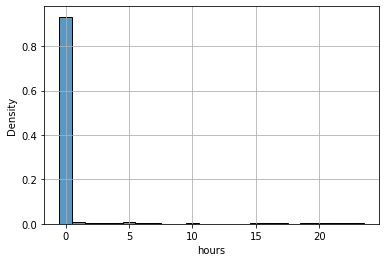

In [20]:
sns.histplot((np.array(time_diffs_12[time_diffs_12<pd.to_timedelta(1e9*60*60*24, unit='ns')])/1e9/3600), stat="density")
plt.xlabel("hours")
plt.grid()

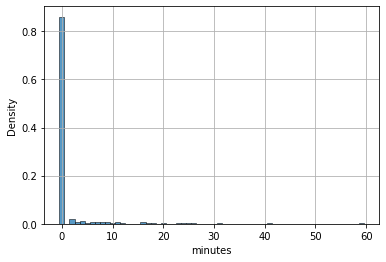

In [21]:
sns.histplot((np.array(time_diffs_12[time_diffs_12<pd.to_timedelta(1e9*60*60, unit='ns')])/1e9/60), stat="density")
plt.xlabel("minutes")
plt.grid()

Не, это не прикольно, таких нам надо будет выкидывать, у кого следующий заказ произошёл в течении 5 минут

Соответственно построим распределение по времени пользователей, наложив аналитическую формулу для оценки вероятности

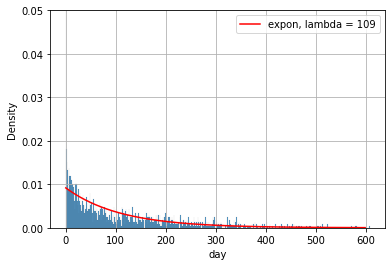

In [22]:
sns.histplot((np.array(time_diffs_12[time_diffs_12>pd.to_timedelta(1e9*60*10, unit='ns')])/1e9/3600/24), stat="density")
x = np.mean((np.array(time_diffs_12[time_diffs_12>pd.to_timedelta(1e9*60*10, unit='ns')])/1e9/3600/24))
plt.ylim(0, 0.05)
plt.plot(np.arange(0, 600), sts.expon(scale=float(x)).pdf(np.arange(0, 600)), color="red", label=f"expon, lambda = {int(x)}")
# plt.xlim(0, 6)
plt.grid()
plt.legend();
plt.xlabel("day");

Теперь получим датасет людей, которых мы оставили для последнего анализа

In [23]:
def extract_fro_group(x):
    x = x.sort_values(by="order_purchase_timestamp")
    return x["order_id"].unique()[0], np.array(x["order_purchase_timestamp"])[1] - np.array(x["order_purchase_timestamp"])[0]

In [24]:
good_with_dt = pd.DataFrame(orders_good.groupby("customer_unique_id").apply(lambda x: extract_fro_group(pd.DataFrame(x))), columns=["all_data"])

C:\Users\Peter\AppData\Local\Temp\ipykernel_18552\3835566104.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  good_with_dt = pd.DataFrame(orders_good.groupby("customer_unique_id").apply(lambda x: extract_fro_group(pd.DataFrame(x))), columns=["all_data"])


Распакуем наши данные в столбцы

In [25]:
good_with_dt["first_order_id"] = good_with_dt["all_data"].apply(lambda x: x[0])
good_with_dt["time_delt"] = good_with_dt["all_data"].apply(lambda x: x[1])

In [26]:
good_with_dt = good_with_dt.drop(columns=["all_data"])

Уберём лишних покупателей, который совершили вторую покупку в следующую секунду

In [27]:
good_with_dt = good_with_dt[good_with_dt["time_delt"]>pd.to_timedelta(1e9*60*2, unit='ns')]

In [28]:
good_with_dt

,first_order_id,time_delt
customer_unique_id,,
004288347e5e88a27ded2bb23747066c,a61d617fbe5bd006e40d3a0988fc844b,170 days 17:23:51
004b45ec5c64187465168251cd1c9c2f,90ae229a4addcfead792e2564554f09c,267 days 07:31:25
00a39521eb40f7012db50455bf083460,7d32c87acba91ed87ebd98310fe1c54d,10 days 13:58:36
011575986092c30523ecb71ff10cb473,0f28d51fdd4828907bdc58b57f672e84,60 days 06:03:19
011b4adcd54683b480c4d841250a987f,f05a68aaa0d8f89e758c7134d53fa22a,176 days 22:49:28
...,...,...
fed519569d16e690df6f89cb99d4e682,adcd0c83cc5c1885f8dfcf0f9db19481,88 days 02:41:30
ff03923ad1eb9e32304deb7f9b2a45c9,1d87599144fe1573be8611bf9f5d5de9,32 days 14:01:33
ff22e30958c13ffe219db7d711e8f564,6ca46f2b9a1592929647682510800e0e,9 days 16:04:38


Сохраним наши данные

In [29]:
good_with_dt.to_csv("good_cust_with_ord_id.csv")

*Выяснил, что в датасете заказы происходят через 1 секунду потому что видно это один заказ, но почему-то его решили разбить на два, там можно увидеть, что они отличаются по содержимому в том числе, что усложняет немного исследование и по-хорошему это надо бы обработать, но в принципе их не очень прям много*

**Посмотрим на покупателей, совершивших только 1 заказ**

In [30]:
orders_bad = cust_with_ord.groupby("customer_unique_id").filter(lambda x: x["customer_unique_id"].count() < 2)

In [31]:
orders_bad

,customer_unique_id,order_id,order_purchase_timestamp,order_status
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,delivered
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,delivered
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,delivered
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,delivered
...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 15:48:17,delivered
99437,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:20:22,delivered
99438,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:11:50,delivered
99439,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,delivered


Найдём последнюю дату в датасете, чтобы понимать сколько времени люди не совершали покупку до окончания сбора данных и посмотрим на эту статистику

In [32]:
max_date = pd.to_datetime(ord_["order_purchase_timestamp"]).max()

In [33]:
orders_bad["time_after_first"] = max_date-pd.to_datetime(orders_bad["order_purchase_timestamp"])

Заодно сравним с распределением для тех, кто сделал вторую покупку

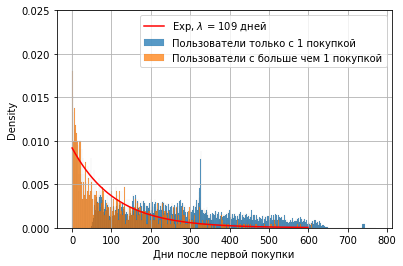

In [36]:
sns.histplot(np.array(orders_bad["time_after_first"])/1e9/3600/24, stat="density", label="Пользователи только с 1 покупкой")
sns.histplot((np.array(time_diffs_12[time_diffs_12>pd.to_timedelta(1e9*60*10, unit='ns')])/1e9/3600/24), stat="density", label="Пользователи с больше чем 1 покупкой")
x = np.mean((np.array(time_diffs_12[time_diffs_12>pd.to_timedelta(1e9*60*10, unit='ns')])/1e9/3600/24))
plt.ylim(0, 0.025)
plt.xlabel("Дни после первой покупки")
plt.plot(np.arange(0, 600), sts.expon(scale=float(x)).pdf(np.arange(0, 600)), color="red", label=f"Exp, $\lambda$ = {int(x)} дней")
plt.grid()
plt.legend()
plt.show()

Для анализа "плохих" покупателей/первых покупок посмотрим на покупки со временем больше 600 дней

In [37]:
too_bad = orders_bad[orders_bad["time_after_first"]>pd.to_timedelta(1e9*3600*24*600, unit='ns')]

In [38]:
too_bad

,customer_unique_id,order_id,order_purchase_timestamp,order_status,time_after_first
49,e021e698833bdeb89dfef3acb2e91f37,38e2829123a2bd1cbe111564824d0abb,2017-01-26 11:14:58,delivered,629 days 06:15:20
111,4bc7250d4b42b3374eb6f41b12429592,42a5f0ddbf1e377e7d31ef5957b62c0a,2017-02-06 16:49:19,delivered,618 days 00:40:59
119,24a5c2b24a4467c37e2f54c1b311de93,56b50d57e6b735968a48a170b8364893,2017-02-08 16:06:47,delivered,616 days 01:23:31
129,96b1c916f245f2462efcde3fce04bc3e,c8f50df8a3e4fc40685c137dd2253eac,2017-02-13 07:34:18,delivered,611 days 09:56:00
144,1d4626b197f66aa6129c135ab09f1a7b,5860cc6e7b232e3c597af193d7760d1a,2017-02-13 10:20:42,delivered,611 days 07:09:36
...,...,...,...,...,...
99215,203443313490c84f08aadead1dbde82f,f5c948dcc066017d10fd2dd3d01cea6d,2017-02-11 13:39:30,delivered,613 days 03:50:48
99288,205a1c797b2c6e626d560900a3ebde6b,12d9fe1a3efa51a7fae337cba819adc1,2017-02-08 13:07:19,shipped,616 days 04:22:59
99330,adc5def00980baefc876eb8023fb053d,54b2059877686b3ab4438912cda13f5a,2017-02-16 19:09:51,delivered,607 days 22:20:27
99359,a7941a8ddbfe8fde0bd23ae272484043,4e44d7b0462e32a51de74a16eac6534e,2017-02-02 16:18:44,delivered,622 days 01:11:34


In [39]:
too_bad.to_csv("bad_cust_with_ord_id.csv")

# Сравнение по категориям выделенных покупателей/покупок

In [40]:
ord_rev = pd.read_csv("hackathon/order_reviews.csv")
ord_it = pd.read_csv("hackathon/orders_items.csv")
prod_tr = pd.read_csv("hackathon/product_category_name_translation.csv")
prods = pd.read_csv("hackathon/products.csv")

C:\Users\Peter\AppData\Local\Temp\ipykernel_18552\2234939508.py:2: DtypeWarning: Columns (1,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  ord_it = pd.read_csv("hackathon/orders_items.csv")


Анализ "плохих" и "хороших" покупок/покупателей

Сначала займёмся items и products

In [41]:
ord_it = ord_it.dropna().drop(columns=["Unnamed: 0", "shipping_limit_date.1", "price.1", "freight_value.1"])

In [42]:
prods = prods.merge(prod_tr, on='product_category_name', how='left')
prods.drop ('product_category_name', axis=1, inplace=True)

In [43]:
prods = prods.drop(columns=["product_name_lenght", "product_description_lenght", "Unnamed: 0"])

Теперь делаем общий датасет для хороших первых покупок, добавляя в good_with_dt ещё order_items, products

In [44]:
items_g = good_with_dt.join(ord_it.set_index("order_id"), on="first_order_id")

In [45]:
items_g = items_g.join(prods.set_index("product_id"), on="product_id")

In [46]:
items_g

,first_order_id,time_delt,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
customer_unique_id,,,,,,,,,,,,,,
004288347e5e88a27ded2bb23747066c,a61d617fbe5bd006e40d3a0988fc844b,170 days 17:23:51,1.0,6e1b14d3cbb5fb3a2c00351007127dfd,7a67c85e85bb2ce8582c35f2203ad736,2017-08-02 14:25:14,229.99,21.10,1.0,1625.0,44.0,24.0,32.0,cool_stuff
004b45ec5c64187465168251cd1c9c2f,90ae229a4addcfead792e2564554f09c,267 days 07:31:25,1.0,b0961721fd839e9982420e807758a2a6,1f50f920176fa81dab994f9023523100,2017-09-12 04:30:20,59.90,37.97,2.0,1850.0,37.0,22.0,40.0,garden_tools
00a39521eb40f7012db50455bf083460,7d32c87acba91ed87ebd98310fe1c54d,10 days 13:58:36,1.0,a42d9c825894f96fc6ed02610891454d,4d6d651bd7684af3fffabd5f08d12e5a,2018-06-04 20:30:43,69.90,26.57,1.0,2200.0,16.0,11.0,11.0,sports_leisure
011575986092c30523ecb71ff10cb473,0f28d51fdd4828907bdc58b57f672e84,60 days 06:03:19,1.0,098c663630a7a81f7d7f42a2ce0b02d7,f9d010e39375d9c91dce3f40b73a2f84,2018-02-22 15:06:43,119.00,15.58,5.0,800.0,25.0,8.0,15.0,toys
011b4adcd54683b480c4d841250a987f,f05a68aaa0d8f89e758c7134d53fa22a,176 days 22:49:28,1.0,169e1fedd1319ca92e90e057e7123005,e9779976487b77c6d4ac45f75ec7afe9,2017-08-28 13:08:00,69.49,16.93,5.0,400.0,28.0,10.0,13.0,sports_leisure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fed519569d16e690df6f89cb99d4e682,adcd0c83cc5c1885f8dfcf0f9db19481,88 days 02:41:30,1.0,774dd887b3739f005c7097b568000536,28ea411b354f14b1a494be4e79f0ce02,2017-12-27 19:30:26,160.00,15.88,3.0,1650.0,36.0,12.0,26.0,bed_bath_table
ff03923ad1eb9e32304deb7f9b2a45c9,1d87599144fe1573be8611bf9f5d5de9,32 days 14:01:33,1.0,6463e442310f2f4f321c83a32d8c662b,c70c1b0d8ca86052f45a432a38b73958,2018-04-29 22:30:38,110.32,13.21,1.0,350.0,19.0,10.0,15.0,health_beauty
ff22e30958c13ffe219db7d711e8f564,6ca46f2b9a1592929647682510800e0e,9 days 16:04:38,1.0,b98992ea80b467987a7fbb88e7f2076a,25be943a321c8938947bdaabca979a90,2018-08-28 17:15:10,145.00,21.46,1.0,10400.0,16.0,68.0,32.0,kitchen_dining_laundry_garden_furniture


Сделаем то же самое для плохих покупателей

In [47]:
items_b = too_bad.join(ord_it.set_index("order_id"), on="order_id")

In [48]:
items_b = items_b.join(prods.set_index("product_id"), on="product_id")

In [49]:
items_b

,customer_unique_id,order_id,order_purchase_timestamp,order_status,time_after_first,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
49,e021e698833bdeb89dfef3acb2e91f37,38e2829123a2bd1cbe111564824d0abb,2017-01-26 11:14:58,delivered,629 days 06:15:20,1.0,5bfcd193eb29c1c8332e2d4ca804d54f,522620dcb18a6b31cd7bdf73665113a9,2017-01-30 11:14:58,223.9,15.74,1.0,340.0,17.0,7.0,16.0,consoles_games
111,4bc7250d4b42b3374eb6f41b12429592,42a5f0ddbf1e377e7d31ef5957b62c0a,2017-02-06 16:49:19,delivered,618 days 00:40:59,1.0,025249b91a565601dc1b8f47ee7a230e,fa1c13f2614d7b5c4749cbc52fecda94,2017-02-10 16:49:19,239.0,12.28,2.0,500.0,16.0,13.0,13.0,watches_gifts
119,24a5c2b24a4467c37e2f54c1b311de93,56b50d57e6b735968a48a170b8364893,2017-02-08 16:06:47,delivered,616 days 01:23:31,1.0,34ca28e1d0a2055f325d4275bad02073,f8db351d8c4c4c22c6835c19a46f01b0,2017-02-12 16:06:47,184.9,15.46,7.0,3300.0,32.0,29.0,51.0,housewares
129,96b1c916f245f2462efcde3fce04bc3e,c8f50df8a3e4fc40685c137dd2253eac,2017-02-13 07:34:18,delivered,611 days 09:56:00,1.0,2b5ae8fa7040dc2ecc8483150f36a667,3f8034bfc6b8b4135534975d49f04c63,2017-02-17 07:34:18,168.0,17.61,6.0,600.0,35.0,7.0,40.0,baby
144,1d4626b197f66aa6129c135ab09f1a7b,5860cc6e7b232e3c597af193d7760d1a,2017-02-13 10:20:42,delivered,611 days 07:09:36,1.0,15d5088ad671c687e6ee89b9ba4e0766,f9244d45189d3a3605499abddeade7d5,2017-03-01 09:20:42,635.9,43.53,1.0,17325.0,35.0,40.0,40.0,small_appliances
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99330,adc5def00980baefc876eb8023fb053d,54b2059877686b3ab4438912cda13f5a,2017-02-16 19:09:51,delivered,607 days 22:20:27,1.0,43a24e051b37c8e88accdfdeecddb71b,3340ef1913fb70d28420f6ceb685c339,2017-02-20 18:09:51,209.9,18.21,1.0,1000.0,37.0,19.0,19.0,computers_accessories
99359,a7941a8ddbfe8fde0bd23ae272484043,4e44d7b0462e32a51de74a16eac6534e,2017-02-02 16:18:44,delivered,622 days 01:11:34,1.0,91b08d34d0ba4db44da2dc382867ba49,b76dba6c951ab00dc4edf0a1aa88037e,2017-02-06 16:18:44,6.9,14.52,2.0,100.0,16.0,4.0,11.0,telephony
99359,a7941a8ddbfe8fde0bd23ae272484043,4e44d7b0462e32a51de74a16eac6534e,2017-02-02 16:18:44,delivered,622 days 01:11:34,2.0,91b08d34d0ba4db44da2dc382867ba49,b76dba6c951ab00dc4edf0a1aa88037e,2017-02-06 16:18:44,6.9,14.52,2.0,100.0,16.0,4.0,11.0,telephony
99359,a7941a8ddbfe8fde0bd23ae272484043,4e44d7b0462e32a51de74a16eac6534e,2017-02-02 16:18:44,delivered,622 days 01:11:34,3.0,91b08d34d0ba4db44da2dc382867ba49,b76dba6c951ab00dc4edf0a1aa88037e,2017-02-06 16:18:44,6.9,14.52,2.0,100.0,16.0,4.0,11.0,telephony


**Если хочется использовать эти два мини датасета для машинки, то в каждый из них можно докидать нехватающих фич**

Немного анализа датасета плохих и хороших

In [50]:
items_g["product_category_name_english"].value_counts().head(7)

product_category_name_english
bed_bath_table           343
furniture_decor          267
sports_leisure           234
health_beauty            191
housewares               161
computers_accessories    160
garden_tools             121
Name: count, dtype: int64

In [51]:
items_b["product_category_name_english"].value_counts().head(7)

product_category_name_english
furniture_decor          399
health_beauty            272
sports_leisure           207
bed_bath_table           163
computers_accessories    143
telephony                127
toys                     121
Name: count, dtype: int64

C:\Users\Peter\AppData\Local\Temp\ipykernel_18552\2453401461.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= items_b["product_category_name_english"].value_counts().head(7).index, y= items_b["product_category_name_english"].value_counts().head(7).values, palette=pal)


Text(0, 0.5, 'Число покупок')

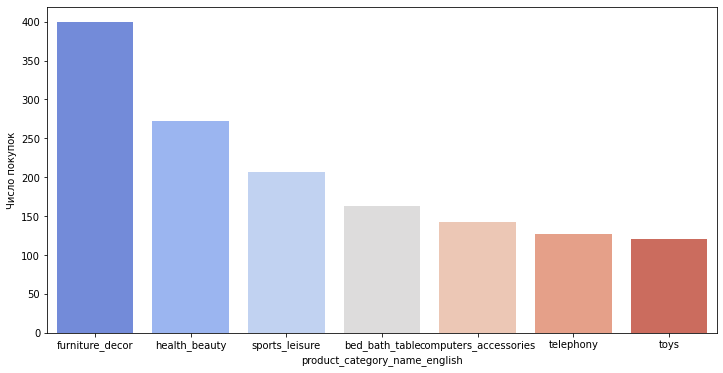

In [58]:
plt.figure(figsize=(12, 6))
pal = sns.color_palette('coolwarm', 7)
sns.barplot(x= items_b["product_category_name_english"].value_counts().head(7).index, y= items_b["product_category_name_english"].value_counts().head(7).values, palette=pal)
plt.ylabel("Число покупок")

C:\Users\Peter\AppData\Local\Temp\ipykernel_18552\127224526.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= items_g["product_category_name_english"].value_counts().head(7).index, y= items_g["product_category_name_english"].value_counts().head(7).values, palette=pal)


Text(0, 0.5, 'Число покупок')

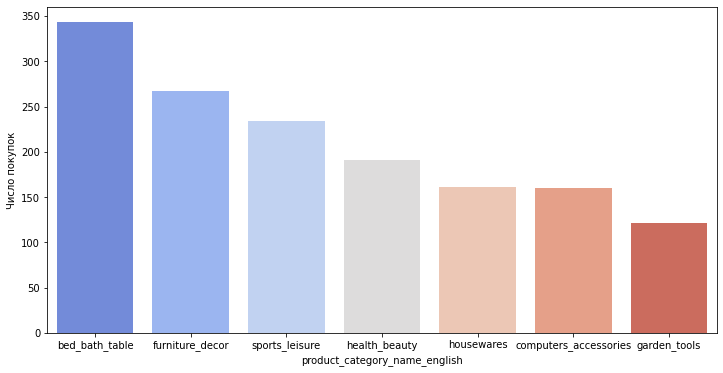

In [59]:
plt.figure(figsize=(12, 6))
pal = sns.color_palette('coolwarm', 7)
sns.barplot(x= items_g["product_category_name_english"].value_counts().head(7).index, y= items_g["product_category_name_english"].value_counts().head(7).values, palette=pal)
plt.ylabel("Число покупок")

Или случайно, или закономерно, но хоть какое-то различие есть как-будто. Жаль, что заказы состоят из одного товара в основном, поэтому тем не менее сложно будет судить о чём-либо

Посмотрим для наиболее частых категорий средние стоимости товаров, среднюю стоимость доставки и средний процент стоимсти доставки от стоимости товара

In [52]:
top_g_cat = items_g["product_category_name_english"].value_counts().head(7).index
top_b_cat = items_b["product_category_name_english"].value_counts().head(7).index

## Анализ цены внутри частых категорий

(0.0, 600.0)

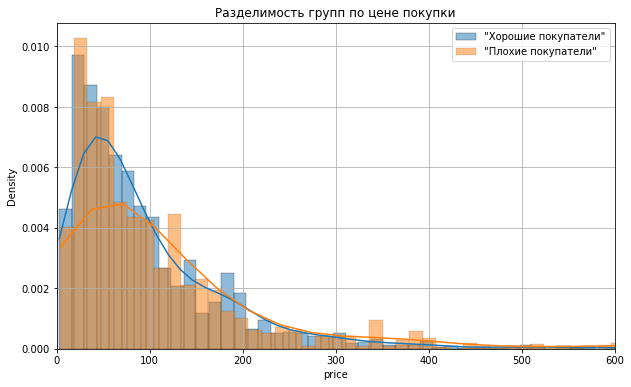

In [68]:
plt.figure(figsize=(10, 6))
sns.histplot(items_g["price"], stat="density", kde="True", label="\"Хорошие покупатели\"")
sns.histplot(items_b["price"], stat="density", kde="True", label="\"Плохие покупатели\"")
plt.title("Разделимость групп по цене покупки")
plt.grid()
plt.legend()
plt.xlim(0, 600)

По частым категориям **хороших** заказов

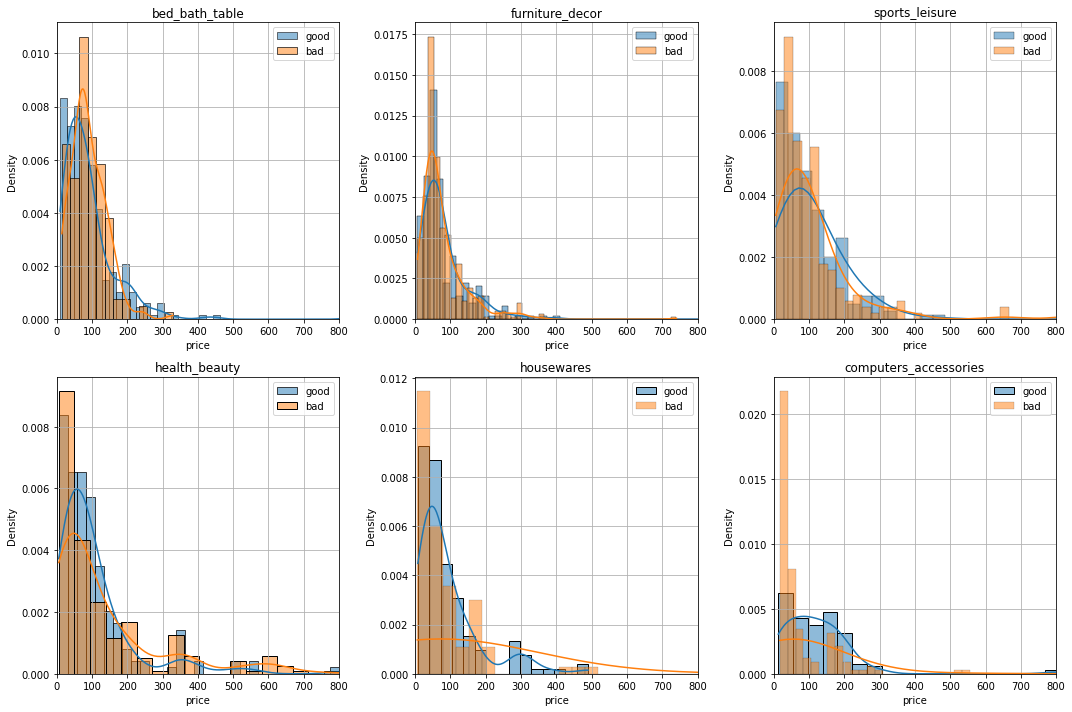

In [54]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_g_cat)-1):
    sns.histplot(items_g[items_g["product_category_name_english"]==top_g_cat[i]]["price"], stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(items_b[items_b["product_category_name_english"]==top_g_cat[i]]["price"], stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_g_cat[i])
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
    ax[i//3][i%3].set_xlim(0, 800)
fig.tight_layout()

По частым категориям **плохих** заказов

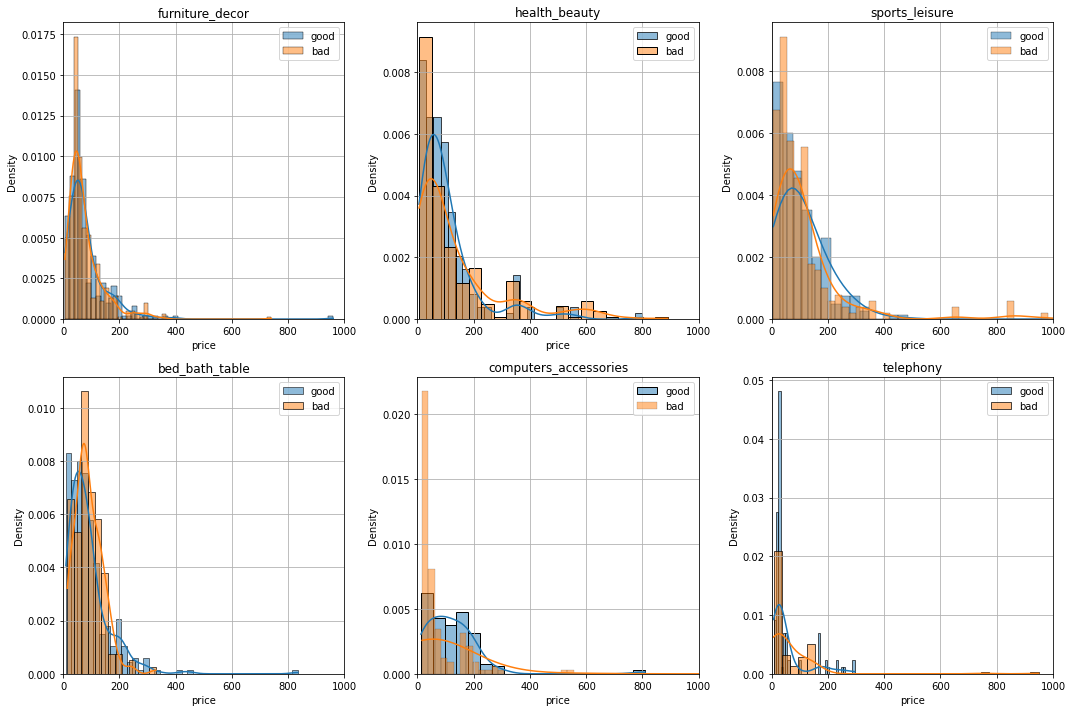

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_b_cat)-1):
    sns.histplot(items_g[items_g["product_category_name_english"]==top_b_cat[i]]["price"], stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(items_b[items_b["product_category_name_english"]==top_b_cat[i]]["price"], stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_b_cat[i])
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
    ax[i//3][i%3].set_xlim(0, 1000)
fig.tight_layout()

## Анализ стоимости доставки внутри частых категорий

(0.0, 125.0)

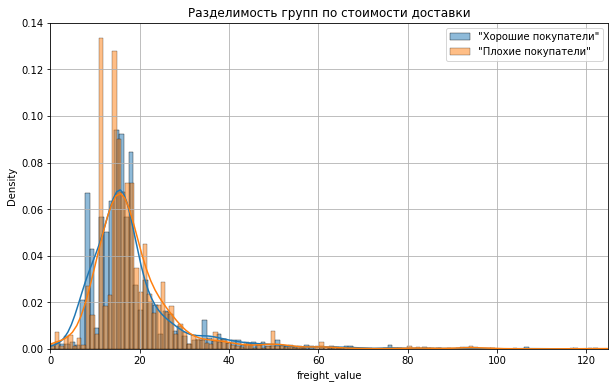

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(items_g["freight_value"], stat="density", kde="True", label="\"Хорошие покупатели\"")
sns.histplot(items_b["freight_value"], stat="density", kde="True", label="\"Плохие покупатели\"")
plt.title("Разделимость групп по стоимости доставки")
plt.grid()
plt.legend()
plt.xlim(0, 125)

По частым категориям **хороших** заказов

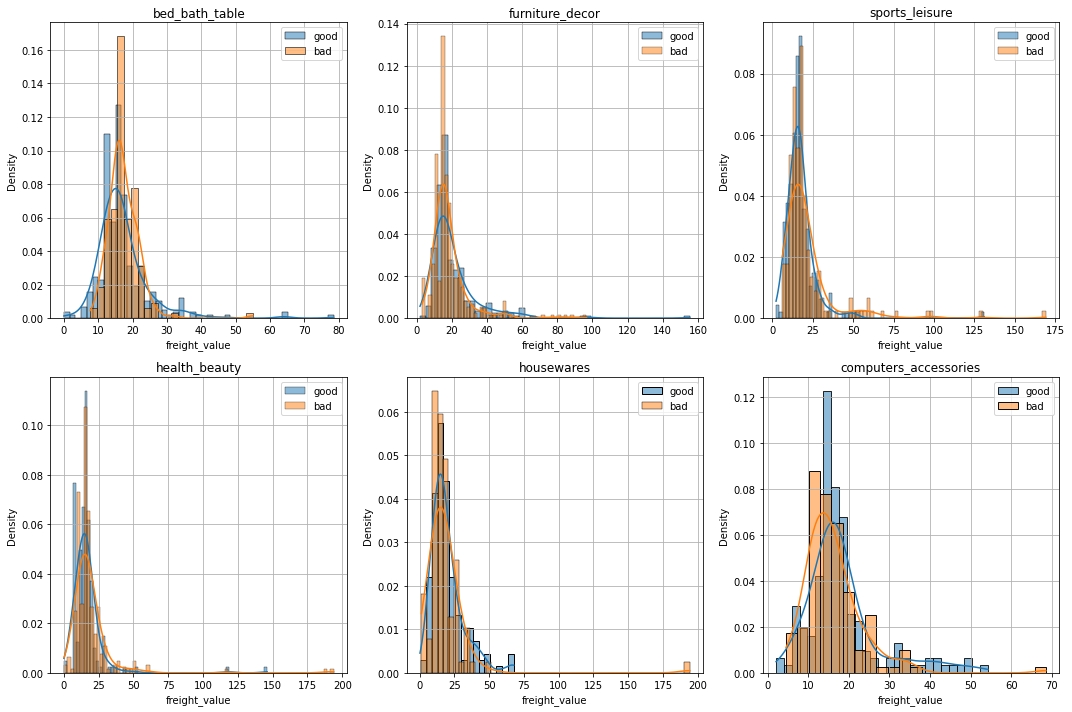

In [53]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_g_cat)-1):
    sns.histplot(items_g[items_g["product_category_name_english"]==top_g_cat[i]]["freight_value"], stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(items_b[items_b["product_category_name_english"]==top_g_cat[i]]["freight_value"], stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_g_cat[i])
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
#     ax[i//3][i%3].set_xlim(0, 200)
fig.tight_layout()

По частым категориям **плохих** заказов

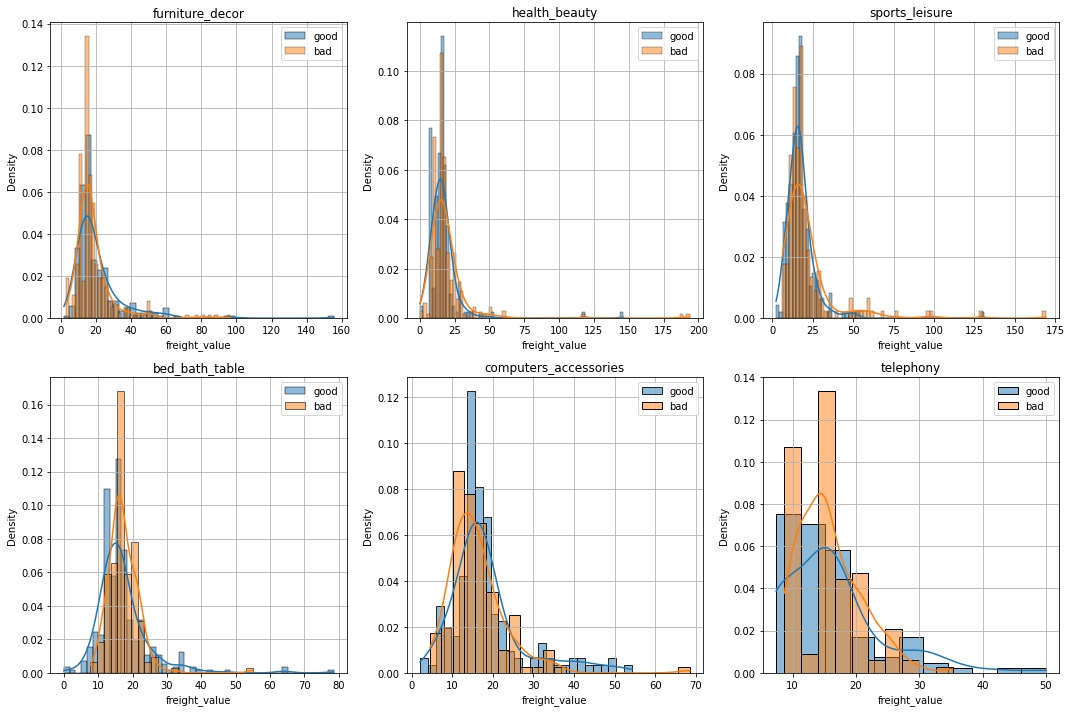

In [54]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_b_cat)-1):
    sns.histplot(items_g[items_g["product_category_name_english"]==top_b_cat[i]]["freight_value"], stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(items_b[items_b["product_category_name_english"]==top_b_cat[i]]["freight_value"], stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_b_cat[i])
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
#     ax[i//3][i%3].set_xlim(0, 1000)
fig.tight_layout()

## Анализ процента доставки внутри частых категорий

(0.0, 200.0)

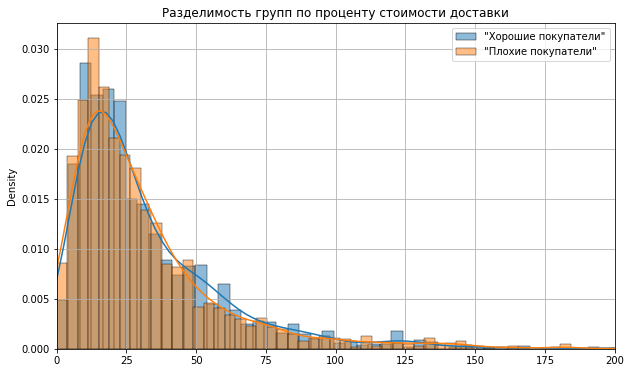

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(100*items_g["freight_value"]/items_g["price"], stat="density", kde="True", label="\"Хорошие покупатели\"")
sns.histplot(100*items_b["freight_value"]/items_b["price"], stat="density", kde="True", label="\"Плохие покупатели\"")
plt.title("Разделимость групп по проценту стоимости доставки")
plt.grid()
plt.legend()
plt.xlim(0, 200)

По частым категориям **хороших** заказов

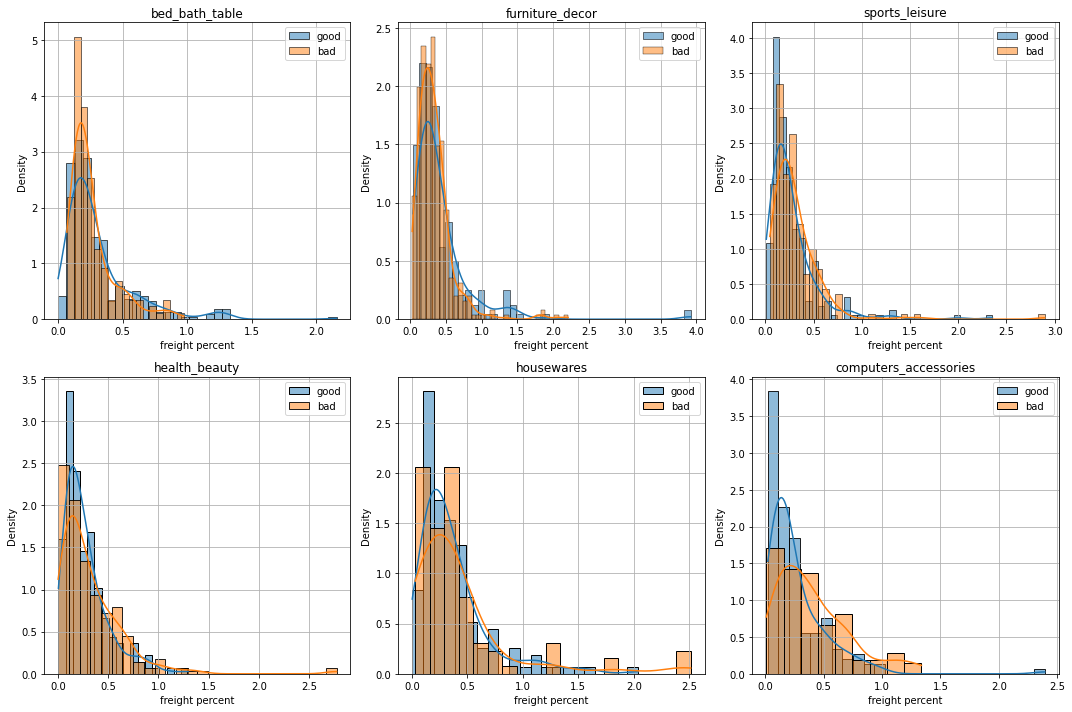

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_g_cat)-1):
    sns.histplot(items_g[items_g["product_category_name_english"]==top_g_cat[i]]["freight_value"]/items_g[items_g["product_category_name_english"]==top_g_cat[i]]["price"], stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(items_b[items_b["product_category_name_english"]==top_g_cat[i]]["freight_value"]/items_b[items_b["product_category_name_english"]==top_g_cat[i]]["price"], stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_g_cat[i])
    ax[i//3][i%3].set_xlabel("freight percent")
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
#     ax[i//3][i%3].set_xlim(0, 200)
fig.tight_layout()

По частым категориям **плохих** заказов

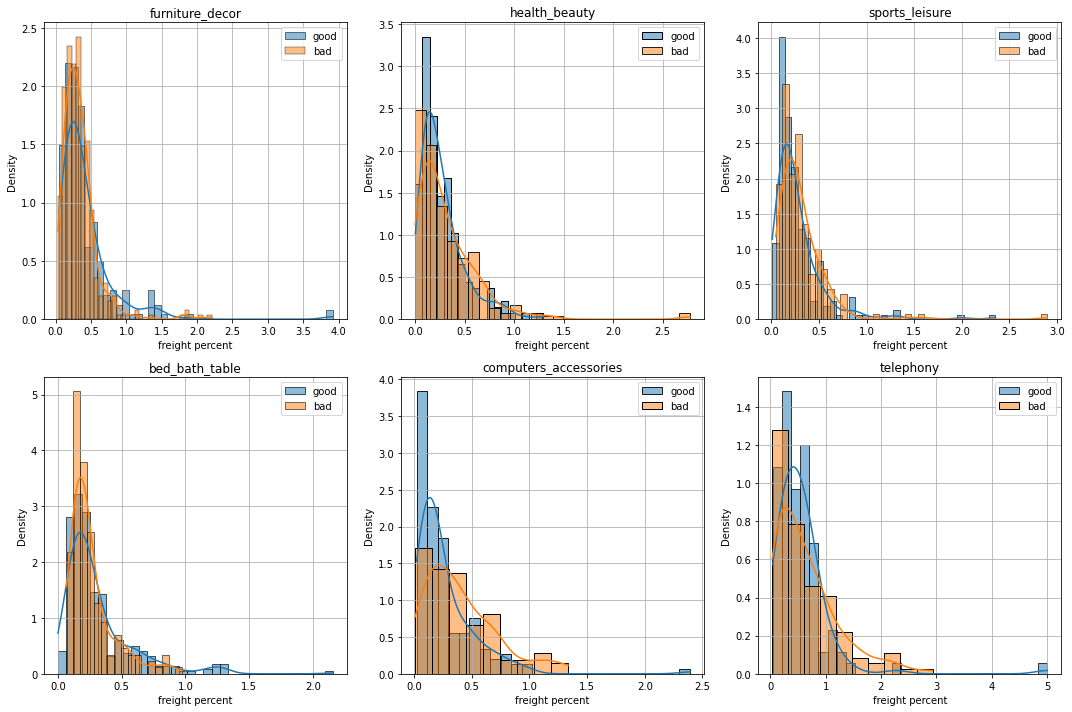

In [56]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_g_cat)-1):
    sns.histplot(items_g[items_g["product_category_name_english"]==top_b_cat[i]]["freight_value"]/items_g[items_g["product_category_name_english"]==top_b_cat[i]]["price"], stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(items_b[items_b["product_category_name_english"]==top_b_cat[i]]["freight_value"]/items_b[items_b["product_category_name_english"]==top_b_cat[i]]["price"], stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_b_cat[i])
    ax[i//3][i%3].set_xlabel("freight percent")
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
#     ax[i//3][i%3].set_xlim(0, 200)
fig.tight_layout()

# Работа с оценками пользователей

## Общий анализ

In [76]:
ord_rev = ord_rev.drop(columns=["Unnamed: 0", "review_comment_title", "review_comment_message"])

In [77]:
rev_g = good_with_dt.join(ord_rev.set_index("order_id"), on="first_order_id")
rev_b = too_bad.join(ord_rev.set_index("order_id"), on="order_id")

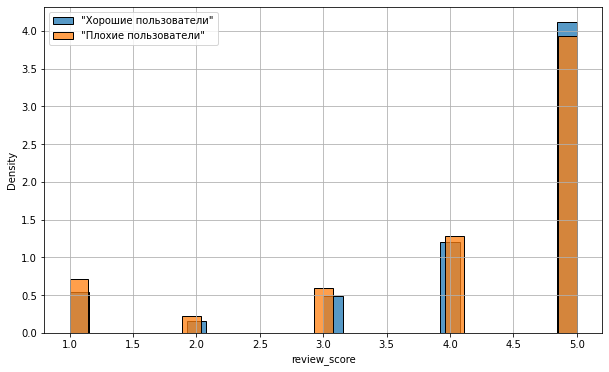

In [78]:
plt.figure(figsize=(10, 6))
sns.histplot(rev_g["review_score"], label=f"\"Хорошие пользователи\"", stat="density")
sns.histplot(rev_b["review_score"], label=f"\"Плохие пользователи\"", stat="density")
plt.grid()
plt.legend()

Просто минимальные различия между группами

## Анализ отзывов внутри категорий

In [68]:
it_rev_b = items_b.join(ord_rev.set_index("order_id"), on="order_id")
it_rev_g = items_g.join(ord_rev.set_index("order_id"), on="first_order_id")

Внутри топа категорий для хороших

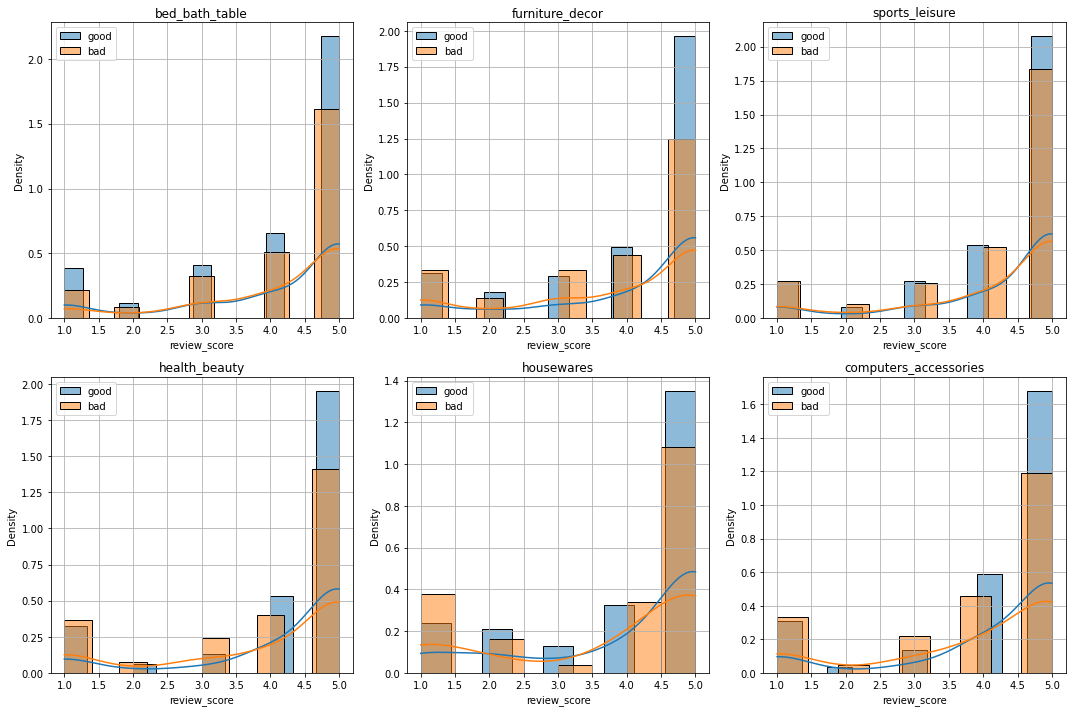

In [69]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_g_cat)-1):
    sns.histplot(it_rev_g[it_rev_g["product_category_name_english"]==top_g_cat[i]]["review_score"], stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(it_rev_b[it_rev_b["product_category_name_english"]==top_g_cat[i]]["review_score"], stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_g_cat[i])
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
#     ax[i//3][i%3].set_xlim(0, 200)
fig.tight_layout()

Внутри топа категорий для плохих

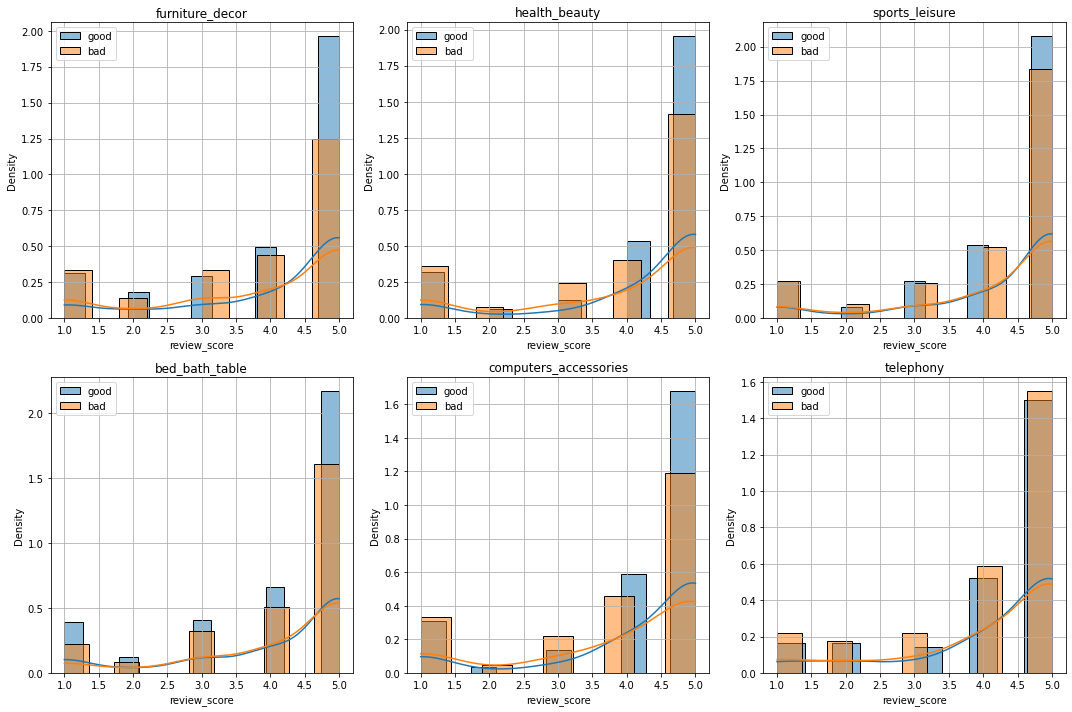

In [70]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_b_cat)-1):
    sns.histplot(it_rev_g[it_rev_g["product_category_name_english"]==top_b_cat[i]]["review_score"], stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(it_rev_b[it_rev_b["product_category_name_english"]==top_b_cat[i]]["review_score"], stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_b_cat[i])
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
#     ax[i//3][i%3].set_xlim(0, 200)
fig.tight_layout()

# Анализ времени доставки

In [80]:
ords = pd.read_csv("hackathon/orders.csv")

In [81]:
it_with_time_b = items_b.join(ords[["order_id", "order_delivered_customer_date"]].set_index("order_id"), on="order_id")
it_with_time_g = items_g.join(ords[["order_id", "order_delivered_customer_date", "order_purchase_timestamp"]].set_index("order_id"), on="first_order_id")

In [82]:
it_with_time_b=it_with_time_b.dropna()

In [83]:
it_with_time_g=it_with_time_g.dropna()

In [84]:
it_with_time_b["order_delivered_customer_date"] = pd.to_datetime(it_with_time_b["order_delivered_customer_date"])
it_with_time_g["order_delivered_customer_date"] = pd.to_datetime(it_with_time_g["order_delivered_customer_date"])

it_with_time_b["order_purchase_timestamp"] = pd.to_datetime(it_with_time_b["order_purchase_timestamp"])
it_with_time_g["order_purchase_timestamp"] = pd.to_datetime(it_with_time_g["order_purchase_timestamp"])

In [85]:
it_with_time_b["delivery_time"] = it_with_time_b["order_delivered_customer_date"] - it_with_time_b["order_purchase_timestamp"]
it_with_time_g["delivery_time"] = it_with_time_g["order_delivered_customer_date"] - it_with_time_g["order_purchase_timestamp"]

(0.0, 60.0)

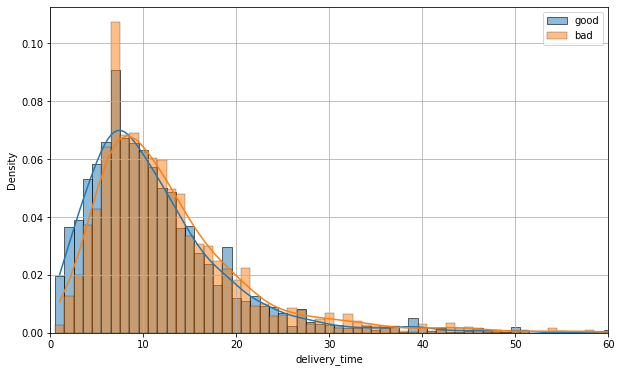

In [89]:
plt.figure(figsize=(10, 6))
sns.histplot(it_with_time_g["delivery_time"]/1e9/3600/24, kde=True, stat="density", label="good")
sns.histplot(it_with_time_b["delivery_time"]/1e9/3600/24, kde=True, stat="density", label="bad")
plt.legend()
plt.grid()
plt.xlim(0, 60)

Внутри топа категорий для хороших

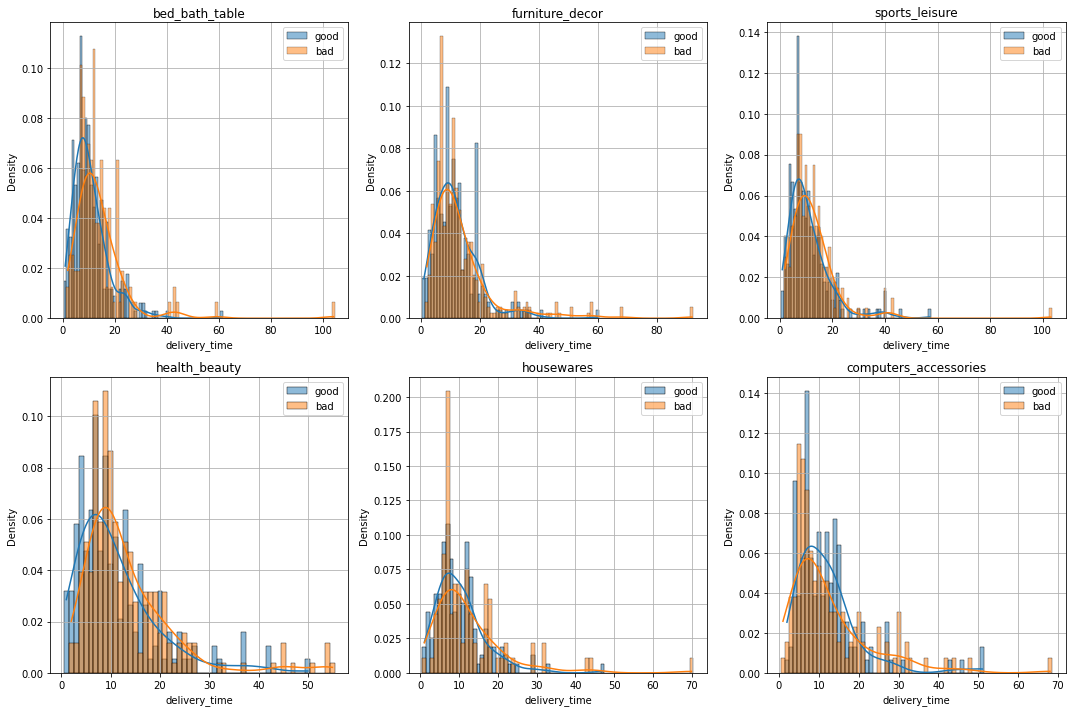

In [129]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_g_cat)-1):
    sns.histplot(it_with_time_g[it_with_time_g["product_category_name_english"]==top_g_cat[i]]["delivery_time"]/1e9/3600/24, stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(it_with_time_b[it_with_time_b["product_category_name_english"]==top_g_cat[i]]["delivery_time"]/1e9/3600/24, stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_g_cat[i])
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
#     ax[i//3][i%3].set_xlim(0, 200)
fig.tight_layout()

Внутри топа категорий для плохих

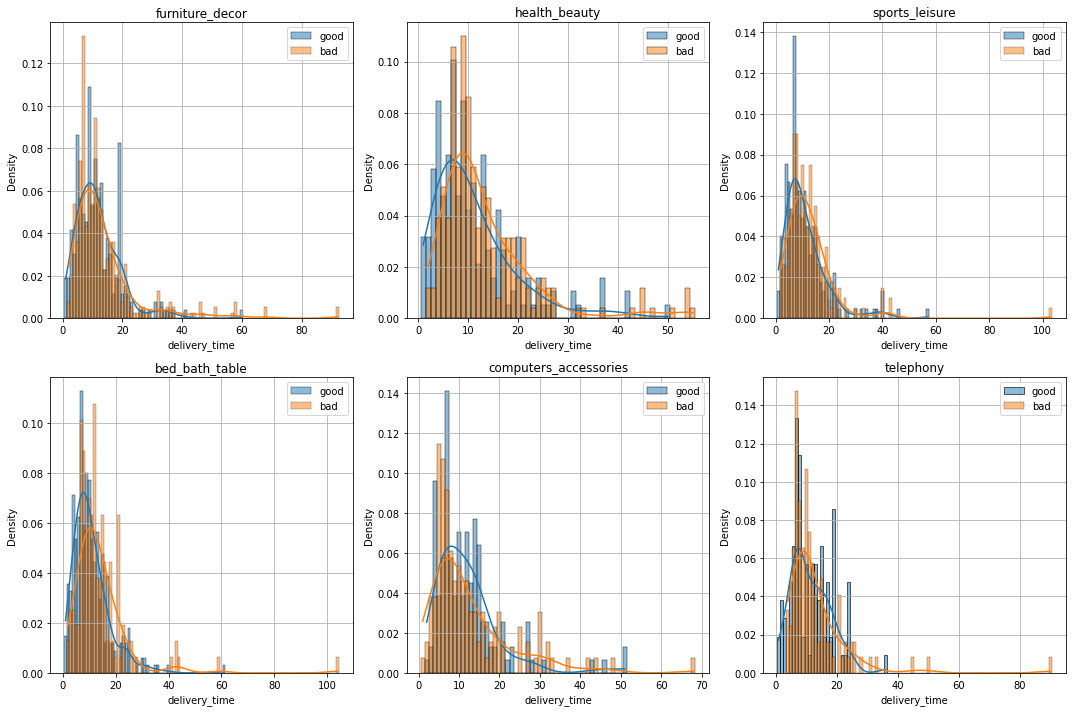

In [130]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(top_b_cat)-1):
    sns.histplot(it_with_time_g[it_with_time_g["product_category_name_english"]==top_b_cat[i]]["delivery_time"]/1e9/3600/24, stat="density", kde="True", ax=ax[i//3][i%3], label="good")
    sns.histplot(it_with_time_b[it_with_time_b["product_category_name_english"]==top_b_cat[i]]["delivery_time"]/1e9/3600/24, stat="density", kde="True", ax=ax[i//3][i%3], label="bad")
    ax[i//3][i%3].set_title(top_b_cat[i])
    ax[i//3][i%3].grid()
    ax[i//3][i%3].legend()
#     ax[i//3][i%3].set_xlim(0, 200)
fig.tight_layout()

# Переразбиение категорий на более крупные группы

In [136]:
prods.product_category_name_english.value_counts().head(60)

product_category_name_english
bed_bath_table                             3029
sports_leisure                             2867
furniture_decor                            2657
health_beauty                              2444
housewares                                 2335
auto                                       1900
computers_accessories                      1639
toys                                       1411
watches_gifts                              1329
telephony                                  1134
baby                                        919
perfumery                                   868
fashion_bags_accessories                    849
stationery                                  849
cool_stuff                                  789
garden_tools                                753
pet_shop                                    719
electronics                                 517
construction_tools_construction             400
home_appliances                             370
luggage_ac